# Imports

In [1]:
%matplotlib inline
import os
import sys
import math
import datetime
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from skimage import io, transform
from collections import defaultdict
from PIL import Image
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.autograd import Function
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision import transforms
import albumentations as A
from albumentations import Normalize, Resize, Compose
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings("ignore")

def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_all_seeds(2022)

In [2]:
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    # transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    transforms.Resize((224, 224)),
    # Transform np.array back to the skimage.Image.
    #transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    # transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((224, 224)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    # transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('./source', transform=source_transform)
target_dataset = ImageFolder('./target', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=64, shuffle=False)

In [3]:
next(iter(target_dataloader))[0].shape

torch.Size([32, 1, 224, 224])

In [4]:
# MODEL_NAME = 'DANN'
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# ROOT_t = 'Bone fracture'
# TRAIN_PATH_t = ROOT_t
# VAL_PATH_t = ROOT_t

# ROOT_s='MURA-v1.1'
# TRAIN_CSV_s = ROOT_s+"/train_image_paths.csv"
# VAL_CSV_s = ROOT_s+"/valid_image_paths.csv"
# TRAIN_PATH_s = ROOT_s+"/train"
# VAL_PATH_s = ROOT_s+"/valid"

# RESNEXT_MEAN = (0.485, 0.456, 0.406)
# RESNEXT_STD = (0.229, 0.224, 0.225)

# IMAGE_RESIZE = (224, 224)
# DEBUG=True
# LEARNING_RATE = 5e-5
# EPOCHS = 32

In [6]:
# with open('./Bone fracture/train.csv','a+') as f:
#     for dirname, _, filenames in os.walk('Bone fracture'):
#         for filename in filenames:
#             f.write(os.path.join(dirname, filename).replace('\\','/')+'\n')

# Pytorch Dataset for train data

In [7]:
# class ClassificationDataset(Dataset):
#     def __init__(self, df ,paths):
#         self.df = df
#         self.base_path = paths
#         self.train_aug = A.Compose(
#     [
#         A.Resize(224, 224, p=1),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.3),
#         A.HueSaturationValue(
#              hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
#          ),
#         A.RandomBrightnessContrast(
#              brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
#          ),
#         A.ChannelShuffle(p=0.5),
#         A.Rotate(15,p=0.2),
#         A.Crop(224//10,224//10,224-224//10,224-224//10,p=1.0),
#         A.RandomBrightnessContrast(p=0.2),    
#         A.RandomGamma(p=0.2),    
#         A.CLAHE(p=0.2),    
#         A.Normalize(
#             mean=RESNEXT_MEAN,
#             std=RESNEXT_STD,
#             max_pixel_value=255.0,
#             p=1.0,
#         ),
#         ToTensorV2(p=1),
#     ],
#     p=1.0,
# )
#         self.val_aug = A.Compose([A.Resize(224,224), 
#                           A.Crop(224//10,224//10,224-224//10,224-224//10,p=1.0),
#                                    A.Normalize(mean=RESNEXT_MEAN, std=RESNEXT_STD, p=1), 
#                                    ToTensorV2(p=1)])
#         self.image_ids = df.image_path.tolist()
#         self.labels = ['0','1']

#     def get_label_for_img(self, image_id):
#         label = self.df.loc[self.df['image_path'] == image_id, 'labels'].iloc[0]
#         label_id = self.labels.index(label)
#         return label_id
        
#     def __getitem__(self, idx):
#         image_id = self.image_ids[idx]
#         image_path = os.path.join(image_id)
#         if self.base_path == TRAIN_PATH:
#             image = self.train_aug(image=cv2.imread(image_path)[:,:,::-1])['image']
#             label = self.get_label_for_img(image_id)
#         elif self.base_path == VAL_PATH:
#             image = self.val_aug(image=cv2.imread(image_path)[:,:,::-1])['image']
#             label = self.get_label_for_img(image_id)
#         return {'image': image, 'label': label, 'path': image_id}

#     def __len__(self):
#         return len(self.image_ids)

In [8]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 5, 2, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 2),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

In [9]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()
m=nn.Sigmoid()
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())
epochs=100

In [10]:
a=torch.FloatTensor([0.1,0.2,0.7])
m = nn.Sigmoid()
a=m(a)
print(a)
l=torch.FloatTensor([0,1,1])
print(torch.sum(a.ge(0.5)==l).item())

tensor([0.5250, 0.5498, 0.6682])
2


# Train loop

In [11]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num, dom_hit = 0.0, 0.0,0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()
        dom_hit+=torch.sum(m(domain_logits).ge(0.5)==domain_label).item()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')
    

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num, dom_hit/(2*total_num)

# train 200 epochs
for epoch in range(epochs):
#     p=epoch/(epochs-1)
#     lambda_p=2/(math.exp(-10*p)+1)-1
    lambda_p = 0.03
    # You should chooose lamnda cleverly.
    train_D_loss, train_F_loss, train_classacc, train_domacc= train_epoch(source_dataloader, target_dataloader, lambda_p)

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, classacc {:6.4f}, domacc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_classacc,train_domacc))
torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
torch.save(label_predictor.state_dict(), f'predictor_model.bin')

epoch   0: train D loss: 0.5411, train F loss: 0.6594, classacc 0.5908, domacc 0.7224
epoch   1: train D loss: 0.5651, train F loss: 0.6457, classacc 0.5965, domacc 0.7043
epoch   2: train D loss: 0.5557, train F loss: 0.6401, classacc 0.6101, domacc 0.7045
epoch   3: train D loss: 0.5757, train F loss: 0.6382, classacc 0.6113, domacc 0.6924
epoch   4: train D loss: 0.5264, train F loss: 0.6262, classacc 0.6212, domacc 0.7338
epoch   5: train D loss: 0.5575, train F loss: 0.6266, classacc 0.6173, domacc 0.7068
epoch   6: train D loss: 0.5440, train F loss: 0.6170, classacc 0.6345, domacc 0.7175
epoch   7: train D loss: 0.4923, train F loss: 0.6031, classacc 0.6461, domacc 0.7617
epoch   8: train D loss: 0.5080, train F loss: 0.6010, classacc 0.6476, domacc 0.7507
epoch   9: train D loss: 0.4819, train F loss: 0.5883, classacc 0.6583, domacc 0.7631
epoch  10: train D loss: 0.4645, train F loss: 0.5881, classacc 0.6700, domacc 0.7793
epoch  11: train D loss: 0.4664, train F loss: 0.5742,

In [12]:
# torch.save(model, 'resnext50-finetuned.bin')
#model = torch.load('resnext50-finetuned.bin')

# Performance Evaluation

In [13]:
# print('Confusion Matrix')
# cm = confusion_matrix(y_preds,y_labels)
# plt.figure(figsize = (10,10))
# sns.set(font_scale=1.4)
# sns.heatmap(cm, annot=True, annot_kws={"size": 10},cmap="YlGnBu")
# plt.show()

In [14]:
# from scipy import interp
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import auc
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# y_preds = label_binarize(y_preds, classes=[0, 1, 2])
# y_labels = label_binarize(y_labels, classes=[0, 1, 2])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_labels[:, i], y_preds[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])       
# ls = ['-', '--', '-.']
# colors = ['#FF0000', '#FF7400', '#0000FF', '#00CC00', '#8B0000', '#5F9EA0', '#800080']
# classes = ['bilek', 'dirsek', 'el']
# plt.figure(figsize=(8,8))
# for i, color in zip(range(3), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,ls=ls[i],
#              label='AUC of class {0} = {1:0.4f}'
#              ''.format(classes[i], roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate',fontsize=15)
# plt.ylabel('True Positive Rate',fontsize=15)
# plt.legend(loc="lower right",fontsize=12)
# plt.show()

In [15]:
# print(classification_report(y_labels, y_preds,digits=4))

In [16]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()

feature_extractor.load_state_dict(torch.load(f'/working/extractor_model.bin'))
label_predictor.load_state_dict(torch.load(f'/working/predictor_model.bin'))

class_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(feature_extractor.parameters()) + list(label_predictor.parameters()), lr=1e-3)

In [17]:
t_feature_extractor = FeatureExtractor().cuda()
t_label_predictor = LabelPredictor().cuda()

t_feature_extractor.load_state_dict(torch.load(f'/working/extractor_model.bin'))
t_label_predictor.load_state_dict(torch.load(f'/working/predictor_model.bin'))
t_feature_extractor.eval()
t_label_predictor.eval()

def new_state(model1, model2, beta=0.9):
    sd1 = model1.state_dict()
    sd2 = model2.state_dict()
    for key in sd2:
        sd2[key] = sd1[key] * (1 - beta) + sd2[key]*beta
        
    model2.load_state_dict(sd2)
    model2.eval()

In [18]:
for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

    source_data = source_data.cuda()
    source_label = source_label.cuda()
    target_data = target_data.cuda()
    mixed_data = torch.cat([source_data, target_data], dim=0)

    class_logits = label_predictor(feature_extractor(target_data))
    with torch.no_grad():
        t_class_logits = t_label_predictor(t_feature_extractor(target_data))
    # loss = cross entropy of classification - lamb * domain binary cross entropy.
    #  The reason why using subtraction is similar to generator loss in disciminator of GAN
    loss_s = class_criterion(class_logits[:source_data.shape[0]], source_label)
    logits,t_logits=class_logits,t_class_logits
    prob2, pseudo_label2 = logits.softmax(dim=1).max(dim=1)
    prob, pseudo_label = t_logits.softmax(dim=1).max(dim=1)
    print(prob2)
    print(prob)
    break

tensor([0.9181, 0.9852, 0.9923, 0.9898, 0.9826, 0.9997, 0.8612, 0.9986, 0.9794,
        0.7415, 0.9899, 0.8685, 0.9983, 0.7771, 0.9915, 0.9987, 0.9690, 0.8243,
        0.9715, 0.9996, 0.9877, 0.6805, 0.9746, 0.7755, 0.9801, 0.9923, 0.6536,
        0.9856, 0.9916, 0.9935, 0.9845, 0.5980], device='cuda:0',
       grad_fn=<MaxBackward0>)
tensor([0.9781, 0.9816, 0.9992, 0.9949, 0.9914, 1.0000, 0.5019, 0.9988, 0.9688,
        0.9438, 0.9971, 0.7251, 0.9953, 0.9335, 0.9927, 0.9992, 0.5098, 0.8901,
        0.8550, 0.9954, 0.9970, 0.6613, 0.9755, 0.9298, 0.9934, 0.9954, 0.9190,
        0.9937, 0.9953, 0.9998, 0.9328, 0.7800], device='cuda:0')


In [19]:
ce = nn.CrossEntropyLoss(reduction='none')
def c_loss(logits, t_logits):
    prob2, pseudo_label2 = logits.softmax(dim=1).max(dim=1)
    prob, pseudo_label = t_logits.softmax(dim=1).max(dim=1)
    flag = prob > 0.95
    return (flag * ce(logits, pseudo_label)).sum() / (flag.sum() + 1e-8), flag.sum(), torch.sum((pseudo_label==pseudo_label2) & flag).item()/(flag.sum().item() + 1e-8)

def train_epoch(source_dataloader, target_dataloader):
    running_loss = 0.0
    total_hit, total_num = 0.0, 0.0
    total_t_used, total_t = 0.0, 0.0
    pacc=0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        mixed_data = torch.cat([source_data, target_data], dim=0)
        
        class_logits = label_predictor(feature_extractor(mixed_data))
        with torch.no_grad():
            t_class_logits = t_label_predictor(t_feature_extractor(target_data))
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss_s = class_criterion(class_logits[:source_data.shape[0]], source_label)
        loss_t, num, pa= c_loss(class_logits[source_data.shape[0]:], t_class_logits)
        loss = loss_s + loss_t
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pacc+=pa
        total_t_used += num
        total_t += target_data.shape[0]
        total_hit += torch.sum(torch.argmax(class_logits[:source_data.shape[0]], dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r') 
        
    new_state(feature_extractor, t_feature_extractor)
    new_state(label_predictor, t_label_predictor)
        
    return running_loss / (i+1), total_hit / total_num, total_t_used/total_t, pacc/(i+1)

# train 200 epochs
print('start training')
epochs = 20
gap = 10
marked_epoch = [0] + [gap*i - 1 for i in range(1, epochs//gap + 1)]
for epoch in range(epochs):
    train_loss, train_acc, used_rate,pred_acc = train_epoch(source_dataloader, target_dataloader)
    if epoch in marked_epoch:
        torch.save(feature_extractor.state_dict(), f'extractor_model_{epoch}.bin')
        torch.save(label_predictor.state_dict(), f'predictor_model_{epoch}.bin')

    print('epoch {:>3d}: train loss: {:6.4f}, acc: {:6.4f}, used rate {:6.4f},pred_acc {:6.4f}'.format(epoch, train_loss, train_acc, used_rate,pred_acc))

torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
torch.save(label_predictor.state_dict(), f'predictor_model.bin')

start training
epoch   0: train loss: 0.1787, acc: 0.9478, used rate 0.6219,pred_acc 0.9849
epoch   1: train loss: 0.1526, acc: 0.9514, used rate 0.6410,pred_acc 0.9914
epoch   2: train loss: 0.1528, acc: 0.9534, used rate 0.6630,pred_acc 0.9922
epoch   3: train loss: 0.1371, acc: 0.9547, used rate 0.6905,pred_acc 0.9947
epoch   4: train loss: 0.1328, acc: 0.9533, used rate 0.7049,pred_acc 0.9960
epoch   5: train loss: 0.1243, acc: 0.9554, used rate 0.7339,pred_acc 0.9970
epoch   6: train loss: 0.1274, acc: 0.9559, used rate 0.7601,pred_acc 0.9954
epoch   7: train loss: 0.1195, acc: 0.9585, used rate 0.7819,pred_acc 0.9952
epoch   8: train loss: 0.1234, acc: 0.9586, used rate 0.8028,pred_acc 0.9957
epoch   9: train loss: 0.1202, acc: 0.9592, used rate 0.8143,pred_acc 0.9962
epoch  10: train loss: 0.1120, acc: 0.9605, used rate 0.8309,pred_acc 0.9963
epoch  11: train loss: 0.1137, acc: 0.9647, used rate 0.8470,pred_acc 0.9954
epoch  12: train loss: 0.1152, acc: 0.9635, used rate 0.8623,

In [20]:
# result = []
# label_predictor.eval()
# feature_extractor.eval()
# for i, (test_data, _) in enumerate(test_dataloader):
#     test_data = test_data.cuda()

#     class_logits = label_predictor(feature_extractor(test_data))

#     x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
#     result.append(x)

# import pandas as pd
# result = np.concatenate(result)
# # Generate your submission
# df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
# df.to_csv('DaNN_submission2.csv',index=False)

In [21]:
result = []
labels = []
label_predictor.eval()
feature_extractor.eval()
for i, (target_data, target_label) in enumerate(target_dataloader):
    test_data = target_data.cuda()
    test_label = target_label.cpu().detach().numpy()
    class_logits = label_predictor(feature_extractor(test_data))
    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)
    labels.append(test_label)

# import pandas as pd
result = np.concatenate(result)
labels = np.concatenate(labels)
# Generate your submission
# df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
# df.to_csv('DaNN_submission2.csv',index=False)

Confusion Matrix


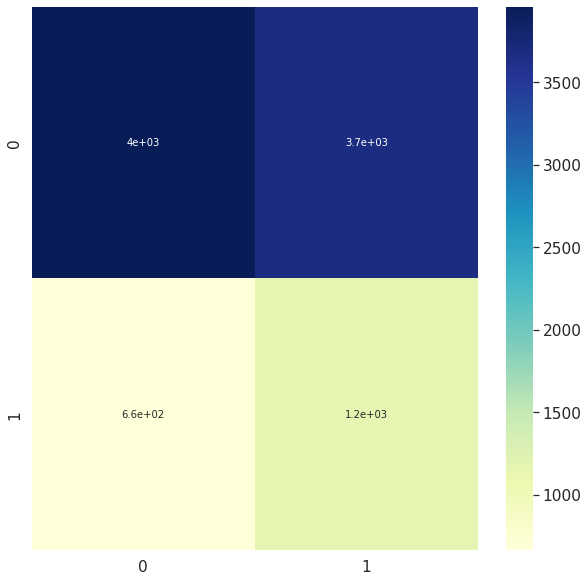

In [22]:
print('Confusion Matrix')
cm = confusion_matrix(result,labels)
plt.figure(figsize = (10,10))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 10},cmap="YlGnBu")
plt.show()

In [23]:
print(classification_report(result,labels,digits=4))

              precision    recall  f1-score   support

           0     0.8564    0.5193    0.6465      7624
           1     0.2428    0.6389    0.3518      1839

    accuracy                         0.5425      9463
   macro avg     0.5496    0.5791    0.4992      9463
weighted avg     0.7371    0.5425    0.5893      9463



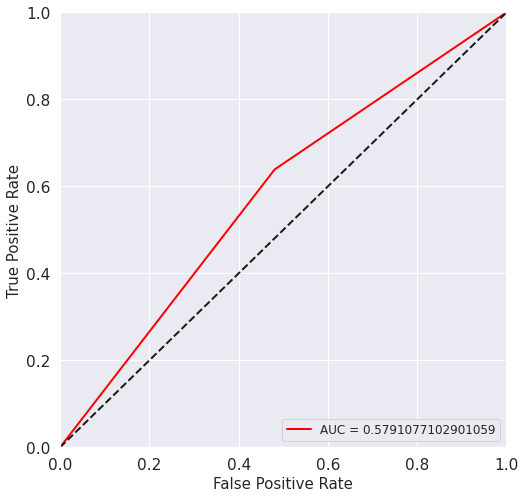

In [24]:
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# result = label_binarize(result, classes=[0, 1])
# labels = label_binarize(labels, classes=[0, 1])
fpr, tpr, _ = roc_curve(result, labels)
roc_auc = auc(fpr, tpr)       
ls = ['-', '--', '-.']
colors = ['#FF0000', '#FF7400', '#0000FF', '#00CC00', '#8B0000', '#5F9EA0', '#800080']
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='#FF0000', lw=2, ls='-',
         label='AUC = {}'
         ''.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.legend(loc="lower right",fontsize=12)
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

In [26]:
class Feature():
    def __init__(self):
        self.X = []
        self.TX = []
        self.labels = []

def get_features(model_list):
    features = []
    for model in model_list:
        model.cuda()
        model.eval()
        features.append(Feature())
    for (x, y), (tx, _) in zip(source_dataloader, target_dataloader):
        x , tx= x.cuda(), tx.cuda()
        for i, model in enumerate(model_list):
            features[i].X.append(model(x).detach().cpu())
            features[i].TX.append(model(tx).detach().cpu())
            features[i].labels.append(y)
    
    for feature in features:
        feature.X = torch.cat(feature.X).numpy()
        feature.TX = torch.cat(feature.TX).numpy()
        feature.labels = torch.cat(feature.labels).numpy()
        
    return features

def visualization(features):
    for i, feature in enumerate(features):
        data = np.concatenate([feature.X, feature.TX])
        num_source = len(feature.labels)
        X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(data)
        # Normalization the processed features 
        x_min, x_max = X_tsne.min(0), X_tsne.max(0)
        X_norm = (X_tsne - x_min) / (x_max - x_min)
    
        plt.figure(figsize=(16, 8))
        plt.subplot(121)
        plt.title(f'epoch {marked_epoch[i]}:distribution of features accross different class')
        plt.scatter(X_norm[:num_source, 0], X_norm[:num_source, 1], c=feature.labels, label='source domain')
        plt.subplot(122)
        plt.title(f'epoch {marked_epoch[i]}:distribution of features accross different domain')
        plt.scatter(X_norm[:num_source, 0], X_norm[:num_source, 1], c='b', label='source domain')
        plt.scatter(X_norm[num_source:, 0], X_norm[num_source:, 1], c='r', label='target domain', alpha=0.5)
        plt.legend()
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18935 samples in 0.008s...
[t-SNE] Computed neighbors for 18935 samples in 15.476s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18935
[t-SNE] Computed conditional probabilities for sample 2000 / 18935
[t-SNE] Computed conditional probabilities for sample 3000 / 18935
[t-SNE] Computed conditional probabilities for sample 4000 / 18935
[t-SNE] Computed conditional probabilities for sample 5000 / 18935
[t-SNE] Computed conditional probabilities for sample 6000 / 18935
[t-SNE] Computed conditional probabilities for sample 7000 / 18935
[t-SNE] Computed conditional probabilities for sample 8000 / 18935
[t-SNE] Computed conditional probabilities for sample 9000 / 18935
[t-SNE] Computed conditional probabilities for sample 10000 / 18935
[t-SNE] Computed conditional probabilities for sample 11000 / 18935
[t-SNE] Computed conditional probabilities for sample 12000 / 18935
[t-SNE] Computed conditional probabilities for sa

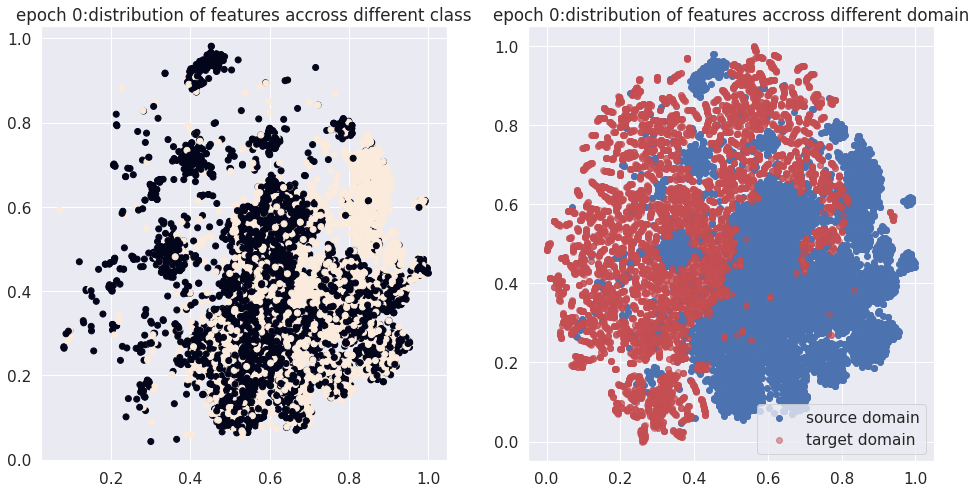

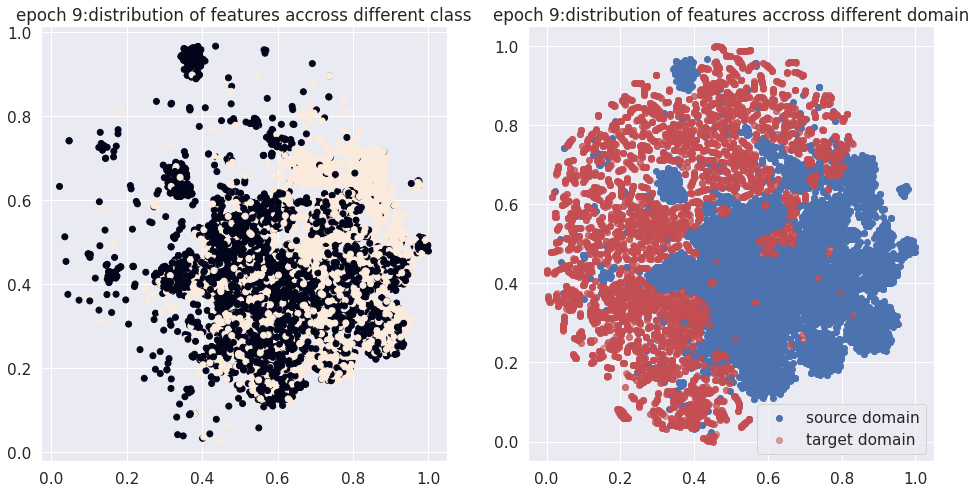

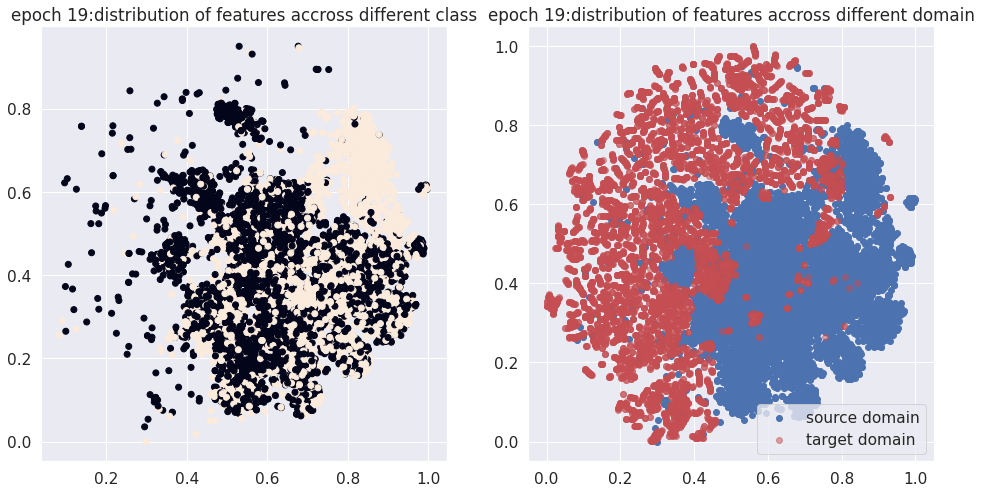

In [27]:
model_list = []
for epoch in marked_epoch:
    model = FeatureExtractor()
    model.load_state_dict(torch.load(f'extractor_model_{epoch}.bin'))
    model_list.append(model)
    
visualization(get_features(model_list))